## Modules

In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import optuna


from time import time_ns
import random
import keras

SEED = 10

random.seed(SEED)
np.random.seed(SEED)
keras.utils.set_random_seed(SEED)

In [2]:
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Tensorflow Version: 2.10.1
Num GPUs: 1


## Funções Uteis

In [3]:
def plot_list(input_list, figsize=(20, 6)):
    """
    Plot a given list.

    Parameters:
        input_list (list): The list of data points to be plotted.

    Returns:
        None: The function displays the plot.
    """
    # Generate x values as indices of the list elements
    x = range(len(input_list))

    # Set the figure size
    plt.figure(figsize=figsize)

    # Plot the data
    plt.plot(x, input_list)

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('BORE_OIL_VOL')
    plt.title('Plot of the BORE_OIL_VOL')

    # Display the plot
    plt.show()

In [4]:
def plot_train_test_data(train, test, split_index):
    """
    Plot the train and test data with a red dashed line indicating the split_index.

    Parameters:
        train (list): The train data to be plotted.
        test (list): The test data to be plotted.
        split_index (int): The index where the data is split between train and test.

    Returns:
        None
    """
    plt.figure(figsize=(20, 6))
    plt.plot(range(len(train)), train, 'k-', label='Train Data')  # Black line for Train
    plt.plot(range(len(train), len(train) + len(test)), test, 'b-', label='Test Data')  # Blue line for Test
    plt.axvline(x=split_index - 0.5, color='r', linestyle='--', label='Split Index')  # Red dashed line at split_index

    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Train and Test Data')
    plt.legend()

    # Show the plot
    plt.show()

In [5]:
def scale_train_test_data(train, test, scaling_type='minmax'):
    """
    Scale the train and test data using the specified scaling method.

    Parameters:
        train (list or numpy array): The train data to be used for fitting the scaler.
        test (list or numpy array): The test data to be transformed using the fitted scaler.
        scaling_type (str, optional): The type of scaling method. Possible values are 'standard',
                                      'minmax' (default), and 'robust'.

    Returns:
        tuple: A tuple containing the transformed train and test data.
    """
    # Convert train and test data to numpy arrays if they are not already
    if not isinstance(train, np.ndarray):
        train = np.array(train)
    if not isinstance(test, np.ndarray):
        test = np.array(test)

    # Initialize the scaler based on the specified scaling_type
    if scaling_type == 'standard':
        scaler = StandardScaler()
    elif scaling_type == 'minmax':
        scaler = MinMaxScaler()
    elif scaling_type == 'robust':
        scaler = RobustScaler()
    else:
        raise ValueError("Invalid scaling_type. Supported values are 'standard', 'minmax', or 'robust'.")

    # Fit the scaler to the train data
    scaler.fit(train.reshape(-1, 1))  # Reshape to a single feature for fitting

    # Transform train and test data using the fitted scaler
    train_scaled = scaler.transform(train.reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.reshape(-1, 1)).flatten()

    return train_scaled, test_scaled

In [6]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare the scaled data for an RNN model.

    Parameters:
        scaled_data (numpy array): The scaled data to be prepared.
        window_size (int): The number of time steps to consider as input for the RNN.
        num_outputs (int, optional): The number of output time steps for prediction (default=1).

    Returns:
        tuple: A tuple containing the input sequences and corresponding output sequences.
    """
    data_size = len(scaled_data)

    # Create empty lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Generate input and output sequences
    for i in range(data_size - window_size - num_outputs + 1):
        input_seq = scaled_data[i : i + window_size]
        output_seq = scaled_data[i + window_size : i + window_size + num_outputs]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)

    # Convert the lists to numpy arrays for RNN input
    input_sequences = np.array(input_sequences)
    output_sequences = np.array(output_sequences)

    return input_sequences, output_sequences

In [7]:
def prepare_rnn_data(scaled_data, window_size, num_outputs=1):
    """
    Prepare a list as a dataset for training an RNN.

    Parameters:
        input_list (list): The list of data points.
        window_size (int): The number of time steps in each window for prediction.
        train_ratio (float, optional): The ratio of training data to the entire dataset. Default is 0.8.
        scaling (str, optional): The scaling method. Options: None (no scaling), "minmax" (Min-Max Scaling),
                                 "standard" (Standardization). Default is None.

    Returns:
        tuple: A tuple containing the train and test datasets in the format (X_train, y_train, X_test, y_test).
              X_train (numpy.ndarray): Training features (input sequences).
              y_train (numpy.ndarray): Training labels (output values to be predicted).
              X_test (numpy.ndarray): Testing features (input sequences).
              y_test (numpy.ndarray): Testing labels (output values to be predicted).
    """
    # Create windows for the RNN
    windows = []
    num_windows = len(scaled_data) - window_size + 1

    for i in range(num_windows):
        window = scaled_data[i:i + window_size]
        windows.append(window)

    # Convert the list of windows to a numpy array
    scaled_data = np.array(windows)

    # Split the dataset into train and test sets
    split_index = int(len(scaled_data) * train_ratio)
    X, y = scaled_data[:split_index, :-1], scaled_data[:split_index, -1]


    return X,y

In [8]:
def plot_result_graphs(train_loss_history, y_train, y_train_pred, y_test, y_test_pred):
        plt.figure(figsize=(14, 10))

        # Plot Train and Test Loss
        plt.subplot(2, 2, 1)
        plt.plot(train_loss_history, label='Train Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Train and Test Loss')
        plt.legend()

        # Plot Train Data and Train Prediction
        plt.subplot(2, 2, 2)
        plt.plot(y_train, label='Train Data', marker='o')
        plt.plot(y_train_pred, label='Train Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Train Data and Train Prediction')
        plt.legend()

        # Plot Test Data and Test Prediction
        plt.subplot(2, 2, 3)
        plt.plot(y_test, label='Test Data', marker='o')
        plt.plot(y_test_pred, label='Test Prediction', marker='x')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Test Data and Test Prediction')
        plt.legend()

        plt.tight_layout()
        plt.show()

## Carregar a Base de dados do Drive

In [9]:
###########################################################
file_name = r"C:\Users\vinicius\Documents\Repositorios\TimeSeriesPredictionFinalProject\src\data\Base_Volve_Pocos.xlsx" # File name
###########################################################

#MELHOR PARA TREINAR E FICAR BOM: 'NO15-9-F-1-C'>'NO15-9-F-15-D' -> Esse cara vai muito para zero
# BOM MAS COM PERFIL SHIFITADO 'NO15-9-F-11-H'~=~'NO15-9-F-12-H'#
sheet_name ='NO15-9-F-1-C' #'NO15-9-F-12-H'# 'NO15-9-F-14-H'#'NO15-9-F-15-D'#'NO15-9-F-11-H'#'NO15-9-F-12-H'#'NO15-9-F-11-H'# 4th sheet
header = 0 # The header is the 2nd row
df_full = pd.read_excel(file_name, sheet_name = sheet_name, header = header)
df_full.head()

,DATEPRD,WELL_BORE_CODE,NPD_WELL_BORE_CODE,NPD_WELL_BORE_NAME,NPD_FIELD_CODE,NPD_FIELD_NAME,NPD_FACILITY_CODE,NPD_FACILITY_NAME,ON_STREAM_HRS,AVG_DOWNHOLE_PRESSURE,...,AVG_CHOKE_UOM,AVG_WHP_P,AVG_WHT_P,DP_CHOKE_SIZE,BORE_OIL_VOL,BORE_GAS_VOL,BORE_WAT_VOL,BORE_WI_VOL,FLOW_KIND,WELL_TYPE
0,2014-04-07,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,0.00000,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,WI
1,2014-04-08,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
2,2014-04-09,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
3,2014-04-10,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,NaN,...,%,0.00000,0.00000,0.00000,0.0,0.0,0.0,NaN,production,OP
4,2014-04-11,NO 15/9-F-1 C,7405,15/9-F-1 C,3420717,VOLVE,369304,MÆRSK INSPIRER,0.0,310.37614,...,%,33.09788,10.47992,33.07195,0.0,0.0,0.0,NaN,production,OP


## Pre processamento

<class 'pandas.core.series.Series'>


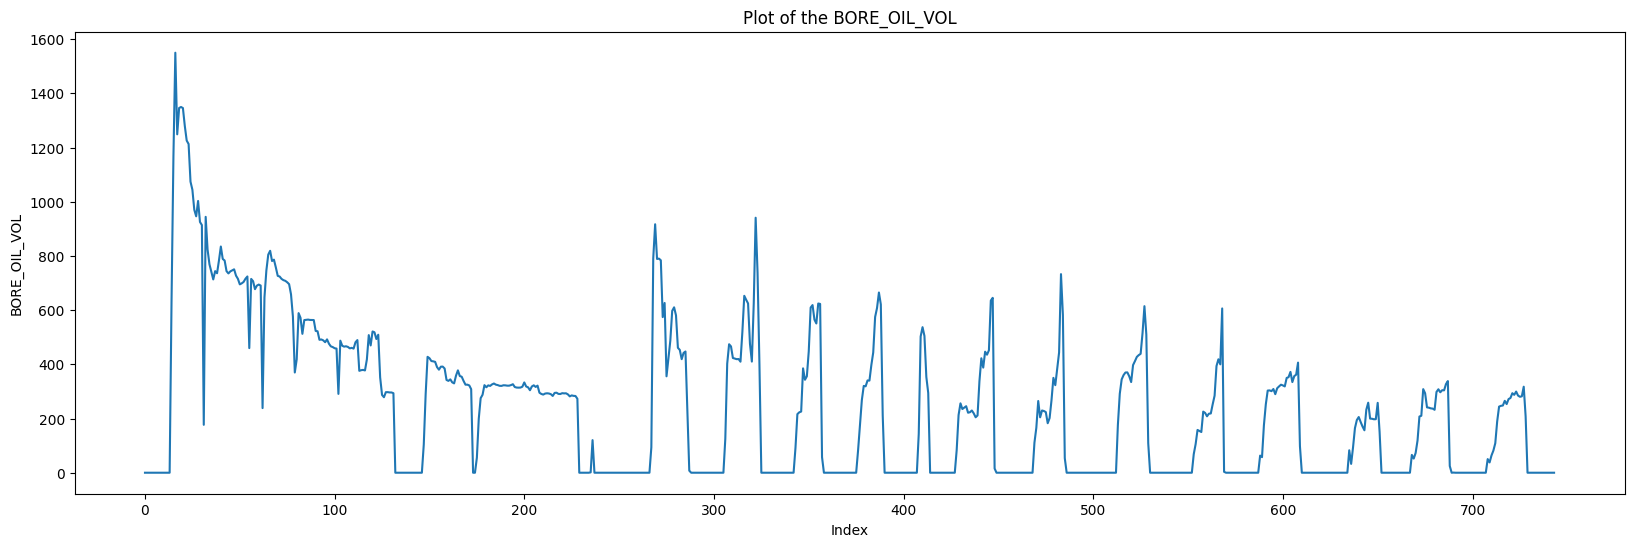

In [10]:
df_filter=df_full[df_full['WELL_TYPE'] != 'WI']
df_filter.isna().sum()
target = df_filter['BORE_OIL_VOL']
print(type(target))
plot_list(target)

## Split Train and Test dataset

In [11]:
train_ratio = 0.8
scaling = "minmax"

# Split the dataset into train and test sets
split_index = int(len(target) * train_ratio)

Train = target[:split_index]
Test = target[split_index:]


In [12]:
print(Train.shape)
print(Test.shape)

(595,)
(149,)


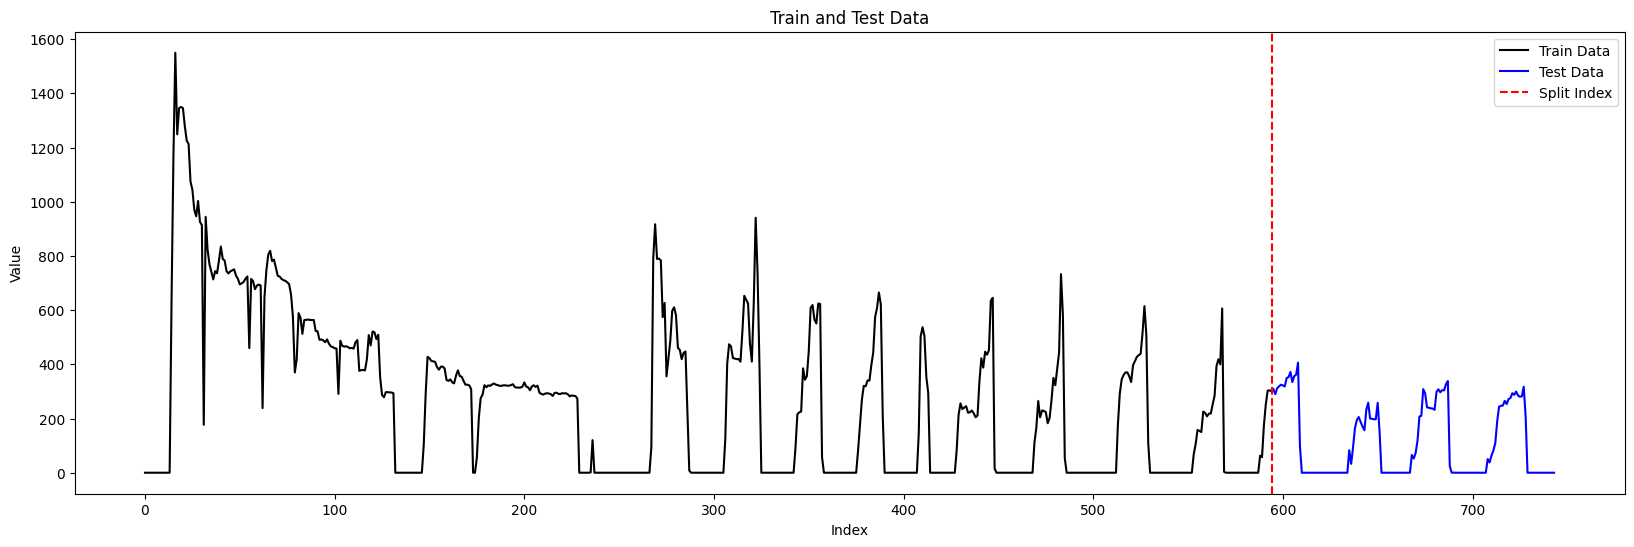

In [13]:
plot_train_test_data(Train, Test, split_index)

## Scaled Data

In [14]:
scaled_train, scaled_test = scale_train_test_data(Train, Test, scaling_type='minmax')
print("Scaled Train Data:", scaled_train[:20])
print()
print("Scaled Test Data:", scaled_test[:20])

Scaled Train Data: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.40744995 0.7526471  1.         0.80571167
 0.8683516  0.87079061]

Scaled Test Data: [0.19930185 0.18703583 0.2011924  0.20558004 0.20958698 0.20788355
 0.20542518 0.22561475 0.2274795  0.24008749 0.21580065 0.23002174
 0.2333899  0.26216762 0.06309806 0.         0.         0.
 0.         0.        ]


## Preparing the X_train, X_test, y_train and y_test

In [15]:
window_size = 14 # Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

In [16]:
# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
# Prediction Index
print(X_train[window_size][0])
print(y_train[0])

0.40744994547718755
0.0


In [17]:
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(465, 13) (465,)
(108, 13) (108,)


In [18]:
epochs = 500 # Choose the number of training epochs
batch_size = 1#5#10 # Choose the batch size for training

In [19]:
n_neurons = 50 # X_train.shape[1] * y_train.shape[1]
n_neurons

50

In [20]:
time_steps = window_size - 1  # Subtract 1 because the last element of each window is the label
input_dim = 1 # Since your input data is of shape (744,) i.e., 1-dimensional
output_dim = 1 # Since you want to predict one value for each sequence

# LSTM Model

In [21]:
# pip install optuna
!pip install optuna-integration

In [22]:
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.optimizers import Adam
import pickle

In [23]:
# Define a callback to save information
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, trial):
        self.trial = trial
        self.best_val_loss = float('inf')
        self.best_model = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs['val_loss']
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.best_model = self.model
        self.trial.report(val_loss, step=epoch)
        if self.trial.should_prune():
            raise optuna.TrialPruned()

In [24]:
def objective(trial):
    # Define the Optuna search space for hyperparameters
    window_size = trial.suggest_int('window_size', 2, 60)  # Adjust the range as needed
    batch_size = trial.suggest_int('batch_size', 1, 20)  # Adjust the range as needed
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 20)
    lstm_units = trial.suggest_int('lstm_units', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2)


    # Set the sequence length - this is the timeframe used to make a single prediction
    num_outputs = 1
    X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
    X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

    time_steps = window_size - 1
    
    # Create the model with the suggested hyperparameters
    model_LSTM = Sequential()
    model_LSTM.reset_states()
    
    for _ in range(n_lstm_layers):
        model_LSTM.add(GRU(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
    model_LSTM.add(GRU(lstm_units, return_sequences=False))
    model_LSTM.add(Dense(output_dim))
    
    # Compile the model with the suggested learning rate
    model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    # Create a custom callback for saving information
    custom_callback = CustomCallback(trial)
    
    # Train the model with your data and use the custom callback
    history = model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[custom_callback], verbose=0)
    
    # Evaluate the model
    val_loss = history.history['val_loss'][-1]
    
    # Save the model as a pkl file
    model_filename = f"model_layer_unit_{trial.number}.pkl"
    with open(model_filename, 'wb') as model_file:
        pickle.dump(model_LSTM, model_file)
    
    return val_loss



In [25]:
# Create an Optuna study
study = optuna.create_study(direction='minimize')



[I 2023-11-02 14:10:58,833] A new study created in memory with name: no-name-0b04098a-5ba2-4101-b751-c033a13c3b0b


In [26]:
# Optimize the model using Optuna
study.optimize(objective, n_trials=250)



INFO:tensorflow:Assets written to: ram://01ad3805-c35a-4ab8-bd6e-3582da3cc2a2/assets


INFO:tensorflow:Assets written to: ram://01ad3805-c35a-4ab8-bd6e-3582da3cc2a2/assets
[I 2023-11-02 14:25:53,188] Trial 0 finished with value: 0.01541853416711092 and parameters: {'window_size': 52, 'batch_size': 7, 'n_lstm_layers': 11, 'lstm_units': 53, 'learning_rate': 0.0046707384277935}. Best is trial 0 with value: 0.01541853416711092.


INFO:tensorflow:Assets written to: ram://a15b909e-261b-4de2-99a5-454ec036369d/assets


INFO:tensorflow:Assets written to: ram://a15b909e-261b-4de2-99a5-454ec036369d/assets
[I 2023-11-02 14:29:50,254] Trial 1 finished with value: 0.00993896834552288 and parameters: {'window_size': 49, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 234, 'learning_rate': 0.00877018526722327}. Best is trial 1 with value: 0.00993896834552288.


INFO:tensorflow:Assets written to: ram://b30225d6-aee7-4117-8763-ffc425a376c7/assets


INFO:tensorflow:Assets written to: ram://b30225d6-aee7-4117-8763-ffc425a376c7/assets
[I 2023-11-02 15:04:29,024] Trial 2 finished with value: 0.03058847039937973 and parameters: {'window_size': 37, 'batch_size': 4, 'n_lstm_layers': 19, 'lstm_units': 137, 'learning_rate': 0.009164487822926908}. Best is trial 1 with value: 0.00993896834552288.


INFO:tensorflow:Assets written to: ram://ffa4b546-a373-4200-807f-579a1f84f0aa/assets


INFO:tensorflow:Assets written to: ram://ffa4b546-a373-4200-807f-579a1f84f0aa/assets
[I 2023-11-02 15:18:36,557] Trial 3 finished with value: 0.008609652519226074 and parameters: {'window_size': 18, 'batch_size': 5, 'n_lstm_layers': 13, 'lstm_units': 62, 'learning_rate': 0.006244410373110506}. Best is trial 3 with value: 0.008609652519226074.


INFO:tensorflow:Assets written to: ram://3987fcff-51e3-4ed8-8f75-75f9fdb4b782/assets


INFO:tensorflow:Assets written to: ram://3987fcff-51e3-4ed8-8f75-75f9fdb4b782/assets
[I 2023-11-02 15:26:54,812] Trial 4 finished with value: 0.009763955138623714 and parameters: {'window_size': 39, 'batch_size': 8, 'n_lstm_layers': 8, 'lstm_units': 68, 'learning_rate': 0.003745009094202822}. Best is trial 3 with value: 0.008609652519226074.
[I 2023-11-02 15:27:12,159] Trial 5 pruned. 
[I 2023-11-02 15:30:21,827] Trial 6 pruned. 
[I 2023-11-02 15:30:37,239] Trial 7 pruned. 


INFO:tensorflow:Assets written to: ram://c764c902-4155-4d1f-bf73-015f6e8b6f22/assets


INFO:tensorflow:Assets written to: ram://c764c902-4155-4d1f-bf73-015f6e8b6f22/assets
[I 2023-11-02 15:32:34,282] Trial 8 finished with value: 0.006911830510944128 and parameters: {'window_size': 25, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 126, 'learning_rate': 0.0037700399233478524}. Best is trial 8 with value: 0.006911830510944128.


INFO:tensorflow:Assets written to: ram://079add53-24fb-4d35-8792-a00d9f2de342/assets


INFO:tensorflow:Assets written to: ram://079add53-24fb-4d35-8792-a00d9f2de342/assets
[I 2023-11-02 15:41:45,372] Trial 9 finished with value: 0.0015096667921170592 and parameters: {'window_size': 54, 'batch_size': 3, 'n_lstm_layers': 2, 'lstm_units': 140, 'learning_rate': 0.002672033973351782}. Best is trial 9 with value: 0.0015096667921170592.


INFO:tensorflow:Assets written to: ram://befad88c-dcc7-4d7e-a2db-077cc8bf3c7a/assets


INFO:tensorflow:Assets written to: ram://befad88c-dcc7-4d7e-a2db-077cc8bf3c7a/assets
[I 2023-11-02 15:47:01,820] Trial 10 finished with value: 0.0025806978810578585 and parameters: {'window_size': 60, 'batch_size': 14, 'n_lstm_layers': 6, 'lstm_units': 191, 'learning_rate': 0.0009584037836744758}. Best is trial 9 with value: 0.0015096667921170592.


INFO:tensorflow:Assets written to: ram://e2b3aabd-2f10-4470-b20a-d888bb5eeab1/assets


INFO:tensorflow:Assets written to: ram://e2b3aabd-2f10-4470-b20a-d888bb5eeab1/assets
[I 2023-11-02 15:51:33,725] Trial 11 finished with value: 0.002036531688645482 and parameters: {'window_size': 59, 'batch_size': 14, 'n_lstm_layers': 5, 'lstm_units': 189, 'learning_rate': 0.0010484698105938449}. Best is trial 9 with value: 0.0015096667921170592.


INFO:tensorflow:Assets written to: ram://07fea297-c2ee-4112-9906-ce1fbe17193c/assets


INFO:tensorflow:Assets written to: ram://07fea297-c2ee-4112-9906-ce1fbe17193c/assets
[I 2023-11-02 15:56:29,196] Trial 12 finished with value: 0.0067983707413077354 and parameters: {'window_size': 60, 'batch_size': 13, 'n_lstm_layers': 5, 'lstm_units': 202, 'learning_rate': 0.000871312467542718}. Best is trial 9 with value: 0.0015096667921170592.
[I 2023-11-02 15:56:34,363] Trial 13 pruned. 
[I 2023-11-02 15:56:42,274] Trial 14 pruned. 
[I 2023-11-02 15:56:47,229] Trial 15 pruned. 
[I 2023-11-02 15:57:00,546] Trial 16 pruned. 
[I 2023-11-02 15:57:38,710] Trial 17 pruned. 
[I 2023-11-02 15:57:42,242] Trial 18 pruned. 
[I 2023-11-02 15:57:49,355] Trial 19 pruned. 
[I 2023-11-02 15:57:52,169] Trial 20 pruned. 
[I 2023-11-02 15:57:58,812] Trial 21 pruned. 
[I 2023-11-02 15:58:09,331] Trial 22 pruned. 
[I 2023-11-02 15:58:13,724] Trial 23 pruned. 
[I 2023-11-02 15:58:20,258] Trial 24 pruned. 
[I 2023-11-02 15:58:28,856] Trial 25 pruned. 
[I 2023-11-02 15:58:38,890] Trial 26 pruned. 


INFO:tensorflow:Assets written to: ram://1a309fbf-1f76-4227-90aa-c84550333fc0/assets


INFO:tensorflow:Assets written to: ram://1a309fbf-1f76-4227-90aa-c84550333fc0/assets
[I 2023-11-02 16:15:49,532] Trial 27 finished with value: 0.002294611418619752 and parameters: {'window_size': 57, 'batch_size': 3, 'n_lstm_layers': 5, 'lstm_units': 34, 'learning_rate': 0.00128124771682306}. Best is trial 9 with value: 0.0015096667921170592.


INFO:tensorflow:Assets written to: ram://e7bffb36-3aea-48f4-a471-6de00624b4e1/assets


INFO:tensorflow:Assets written to: ram://e7bffb36-3aea-48f4-a471-6de00624b4e1/assets
[I 2023-11-02 16:24:26,323] Trial 28 finished with value: 0.006546848453581333 and parameters: {'window_size': 47, 'batch_size': 3, 'n_lstm_layers': 2, 'lstm_units': 37, 'learning_rate': 0.002880620792360053}. Best is trial 9 with value: 0.0015096667921170592.
[I 2023-11-02 16:24:40,962] Trial 29 pruned. 
[I 2023-11-02 16:24:46,933] Trial 30 pruned. 
[I 2023-11-02 16:25:03,628] Trial 31 pruned. 
[I 2023-11-02 16:25:08,821] Trial 32 pruned. 
[I 2023-11-02 16:25:17,902] Trial 33 pruned. 


INFO:tensorflow:Assets written to: ram://aa0263c6-e905-4a68-854e-9bbbc734ce75/assets


INFO:tensorflow:Assets written to: ram://aa0263c6-e905-4a68-854e-9bbbc734ce75/assets
[I 2023-11-02 16:31:07,432] Trial 34 finished with value: 0.0015232242876663804 and parameters: {'window_size': 55, 'batch_size': 5, 'n_lstm_layers': 2, 'lstm_units': 131, 'learning_rate': 0.0016591764191965135}. Best is trial 9 with value: 0.0015096667921170592.


INFO:tensorflow:Assets written to: ram://e020a3ed-b759-46ed-a302-2c1000e51647/assets


INFO:tensorflow:Assets written to: ram://e020a3ed-b759-46ed-a302-2c1000e51647/assets
[I 2023-11-02 16:37:49,002] Trial 35 finished with value: 0.0030692678410559893 and parameters: {'window_size': 48, 'batch_size': 4, 'n_lstm_layers': 2, 'lstm_units': 129, 'learning_rate': 0.0018191196870261054}. Best is trial 9 with value: 0.0015096667921170592.
[I 2023-11-02 16:37:55,162] Trial 36 pruned. 
[I 2023-11-02 16:38:03,039] Trial 37 pruned. 


INFO:tensorflow:Assets written to: ram://887c0551-4ea6-4b80-b424-e00365a0780d/assets


INFO:tensorflow:Assets written to: ram://887c0551-4ea6-4b80-b424-e00365a0780d/assets
[I 2023-11-02 16:44:00,307] Trial 38 finished with value: 0.0021614646539092064 and parameters: {'window_size': 52, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 60, 'learning_rate': 0.0024194740630027896}. Best is trial 9 with value: 0.0015096667921170592.


INFO:tensorflow:Assets written to: ram://d007507f-fa49-4e20-9fa9-6b0476191cb8/assets


INFO:tensorflow:Assets written to: ram://d007507f-fa49-4e20-9fa9-6b0476191cb8/assets
[I 2023-11-02 16:46:10,356] Trial 39 finished with value: 0.00314936856739223 and parameters: {'window_size': 36, 'batch_size': 9, 'n_lstm_layers': 1, 'lstm_units': 54, 'learning_rate': 0.0025205703204915922}. Best is trial 9 with value: 0.0015096667921170592.
[I 2023-11-02 16:46:14,625] Trial 40 pruned. 
[I 2023-11-02 16:46:29,256] Trial 41 pruned. 
[I 2023-11-02 16:46:33,102] Trial 42 pruned. 


INFO:tensorflow:Assets written to: ram://f25c994e-2712-49ed-97ad-f655de2b41d0/assets


INFO:tensorflow:Assets written to: ram://f25c994e-2712-49ed-97ad-f655de2b41d0/assets
[I 2023-11-02 16:56:12,240] Trial 43 finished with value: 0.0015663832891732454 and parameters: {'window_size': 57, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 73, 'learning_rate': 0.0023413209935132457}. Best is trial 9 with value: 0.0015096667921170592.


INFO:tensorflow:Assets written to: ram://86ef678a-7b28-4323-be7b-9d0611552004/assets


INFO:tensorflow:Assets written to: ram://86ef678a-7b28-4323-be7b-9d0611552004/assets
[I 2023-11-02 17:00:04,485] Trial 44 finished with value: 0.0024287705309689045 and parameters: {'window_size': 49, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 67, 'learning_rate': 0.0038346944571849466}. Best is trial 9 with value: 0.0015096667921170592.


INFO:tensorflow:Assets written to: ram://26e4bfb6-9151-45ea-a9d5-428f5ed45541/assets


INFO:tensorflow:Assets written to: ram://26e4bfb6-9151-45ea-a9d5-428f5ed45541/assets
[I 2023-11-02 17:09:59,991] Trial 45 finished with value: 0.001449268078431487 and parameters: {'window_size': 57, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 81, 'learning_rate': 0.002212295653813113}. Best is trial 45 with value: 0.001449268078431487.


INFO:tensorflow:Assets written to: ram://efb651ac-fe47-4b48-ad95-363602ea1dc5/assets


INFO:tensorflow:Assets written to: ram://efb651ac-fe47-4b48-ad95-363602ea1dc5/assets
[I 2023-11-02 17:25:13,100] Trial 46 finished with value: 0.004821795504540205 and parameters: {'window_size': 57, 'batch_size': 2, 'n_lstm_layers': 2, 'lstm_units': 108, 'learning_rate': 0.0021261768276168145}. Best is trial 45 with value: 0.001449268078431487.
[I 2023-11-02 17:25:24,016] Trial 47 pruned. 
[I 2023-11-02 17:25:30,176] Trial 48 pruned. 


INFO:tensorflow:Assets written to: ram://cea155b4-6fe1-425e-88bf-247527acaf93/assets


INFO:tensorflow:Assets written to: ram://cea155b4-6fe1-425e-88bf-247527acaf93/assets
[I 2023-11-02 17:31:21,803] Trial 49 finished with value: 0.002263593953102827 and parameters: {'window_size': 46, 'batch_size': 6, 'n_lstm_layers': 3, 'lstm_units': 146, 'learning_rate': 0.0016407136054802324}. Best is trial 45 with value: 0.001449268078431487.
[I 2023-11-02 17:31:27,035] Trial 50 pruned. 


INFO:tensorflow:Assets written to: ram://da5b6ca1-55fc-4f8b-96df-bfe8b6ee271c/assets


INFO:tensorflow:Assets written to: ram://da5b6ca1-55fc-4f8b-96df-bfe8b6ee271c/assets
[I 2023-11-02 17:41:49,198] Trial 51 finished with value: 0.0026954428758472204 and parameters: {'window_size': 52, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 97, 'learning_rate': 0.0024032016214228257}. Best is trial 45 with value: 0.001449268078431487.


INFO:tensorflow:Assets written to: ram://62b25a9f-b222-4d4b-917d-36ad2917d14b/assets


INFO:tensorflow:Assets written to: ram://62b25a9f-b222-4d4b-917d-36ad2917d14b/assets
[I 2023-11-02 17:48:00,420] Trial 52 finished with value: 0.003862685291096568 and parameters: {'window_size': 50, 'batch_size': 4, 'n_lstm_layers': 2, 'lstm_units': 86, 'learning_rate': 0.0029717118121360977}. Best is trial 45 with value: 0.001449268078431487.
[I 2023-11-02 17:48:18,235] Trial 53 pruned. 
[I 2023-11-02 17:48:24,223] Trial 54 pruned. 


INFO:tensorflow:Assets written to: ram://4e539003-d265-4126-8a72-84f101ca4f20/assets


INFO:tensorflow:Assets written to: ram://4e539003-d265-4126-8a72-84f101ca4f20/assets
[I 2023-11-02 17:55:01,876] Trial 55 finished with value: 0.003043839242309332 and parameters: {'window_size': 60, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 168, 'learning_rate': 0.0004733386834899321}. Best is trial 45 with value: 0.001449268078431487.
[I 2023-11-02 17:55:10,566] Trial 56 pruned. 
[I 2023-11-02 17:55:19,178] Trial 57 pruned. 
[I 2023-11-02 17:55:23,475] Trial 58 pruned. 


INFO:tensorflow:Assets written to: ram://6180f68c-43b4-4a8b-b2b8-406daaa3687c/assets


INFO:tensorflow:Assets written to: ram://6180f68c-43b4-4a8b-b2b8-406daaa3687c/assets
[I 2023-11-02 17:57:40,635] Trial 59 finished with value: 0.0022435826249420643 and parameters: {'window_size': 44, 'batch_size': 9, 'n_lstm_layers': 1, 'lstm_units': 74, 'learning_rate': 0.0022668060191528804}. Best is trial 45 with value: 0.001449268078431487.
[I 2023-11-02 17:57:43,654] Trial 60 pruned. 


INFO:tensorflow:Assets written to: ram://10eba373-5428-406b-a575-d3aa23656ea1/assets


INFO:tensorflow:Assets written to: ram://10eba373-5428-406b-a575-d3aa23656ea1/assets
[I 2023-11-02 18:00:12,508] Trial 61 finished with value: 0.0047163222916424274 and parameters: {'window_size': 49, 'batch_size': 8, 'n_lstm_layers': 1, 'lstm_units': 75, 'learning_rate': 0.0021687844731214804}. Best is trial 45 with value: 0.001449268078431487.
[I 2023-11-02 18:00:14,599] Trial 62 pruned. 
[I 2023-11-02 18:00:19,205] Trial 63 pruned. 
[I 2023-11-02 18:00:41,623] Trial 64 pruned. 
[I 2023-11-02 18:00:45,811] Trial 65 pruned. 


INFO:tensorflow:Assets written to: ram://d7ac64ef-8416-40af-bd51-5d4e24a7f363/assets


INFO:tensorflow:Assets written to: ram://d7ac64ef-8416-40af-bd51-5d4e24a7f363/assets
[I 2023-11-02 18:26:07,037] Trial 66 finished with value: 0.005506697576493025 and parameters: {'window_size': 53, 'batch_size': 1, 'n_lstm_layers': 2, 'lstm_units': 72, 'learning_rate': 0.0005016519876294872}. Best is trial 45 with value: 0.001449268078431487.
[I 2023-11-02 18:26:09,876] Trial 67 pruned. 
[I 2023-11-02 18:26:15,003] Trial 68 pruned. 
[I 2023-11-02 18:26:20,522] Trial 69 pruned. 


INFO:tensorflow:Assets written to: ram://d10bee2c-ca8f-4dcb-a1f2-83a46fd42e47/assets


INFO:tensorflow:Assets written to: ram://d10bee2c-ca8f-4dcb-a1f2-83a46fd42e47/assets
[I 2023-11-02 18:28:51,591] Trial 70 finished with value: 0.0024371943436563015 and parameters: {'window_size': 46, 'batch_size': 12, 'n_lstm_layers': 2, 'lstm_units': 167, 'learning_rate': 0.003123422290236194}. Best is trial 45 with value: 0.001449268078431487.


INFO:tensorflow:Assets written to: ram://27629896-005e-4411-8830-25c7f0843bf1/assets


INFO:tensorflow:Assets written to: ram://27629896-005e-4411-8830-25c7f0843bf1/assets
[I 2023-11-02 18:34:42,643] Trial 71 finished with value: 0.01929548941552639 and parameters: {'window_size': 46, 'batch_size': 6, 'n_lstm_layers': 3, 'lstm_units': 151, 'learning_rate': 0.0016807374044823134}. Best is trial 45 with value: 0.001449268078431487.
[I 2023-11-02 18:34:47,281] Trial 72 pruned. 


INFO:tensorflow:Assets written to: ram://46437b88-ffc3-4a1f-ae76-b90f97ccbed7/assets


INFO:tensorflow:Assets written to: ram://46437b88-ffc3-4a1f-ae76-b90f97ccbed7/assets
[I 2023-11-02 18:40:28,364] Trial 73 finished with value: 0.0013797571882605553 and parameters: {'window_size': 56, 'batch_size': 5, 'n_lstm_layers': 2, 'lstm_units': 132, 'learning_rate': 0.0017037696373968523}. Best is trial 73 with value: 0.0013797571882605553.
[I 2023-11-02 18:40:32,131] Trial 74 pruned. 
[I 2023-11-02 18:40:36,258] Trial 75 pruned. 
[I 2023-11-02 18:40:39,462] Trial 76 pruned. 
[I 2023-11-02 18:40:41,619] Trial 77 pruned. 
[I 2023-11-02 18:40:53,203] Trial 78 pruned. 
[I 2023-11-02 18:41:01,208] Trial 79 pruned. 
[I 2023-11-02 18:41:07,886] Trial 80 pruned. 
[I 2023-11-02 18:41:12,200] Trial 81 pruned. 
[I 2023-11-02 18:41:16,109] Trial 82 pruned. 
[I 2023-11-02 18:41:18,954] Trial 83 pruned. 
[I 2023-11-02 18:41:24,581] Trial 84 pruned. 


INFO:tensorflow:Assets written to: ram://2426a605-903c-4273-8147-8114f3eb9287/assets


INFO:tensorflow:Assets written to: ram://2426a605-903c-4273-8147-8114f3eb9287/assets
[I 2023-11-02 18:50:21,074] Trial 85 finished with value: 0.004758747294545174 and parameters: {'window_size': 59, 'batch_size': 3, 'n_lstm_layers': 2, 'lstm_units': 162, 'learning_rate': 0.002479459200444335}. Best is trial 73 with value: 0.0013797571882605553.


INFO:tensorflow:Assets written to: ram://4d3f7a3b-8415-415a-8180-6cd23f94cd27/assets


INFO:tensorflow:Assets written to: ram://4d3f7a3b-8415-415a-8180-6cd23f94cd27/assets
[I 2023-11-02 18:52:10,802] Trial 86 finished with value: 0.005479155108332634 and parameters: {'window_size': 36, 'batch_size': 11, 'n_lstm_layers': 1, 'lstm_units': 124, 'learning_rate': 0.0011386294160513188}. Best is trial 73 with value: 0.0013797571882605553.
[I 2023-11-02 18:52:15,392] Trial 87 pruned. 
[I 2023-11-02 18:52:18,815] Trial 88 pruned. 
[I 2023-11-02 18:52:24,099] Trial 89 pruned. 
[I 2023-11-02 18:52:26,397] Trial 90 pruned. 
[I 2023-11-02 18:52:37,697] Trial 91 pruned. 
[I 2023-11-02 18:52:43,824] Trial 92 pruned. 


INFO:tensorflow:Assets written to: ram://0ca3c52f-868f-415c-9985-8780633b68d8/assets


INFO:tensorflow:Assets written to: ram://0ca3c52f-868f-415c-9985-8780633b68d8/assets
[I 2023-11-02 19:05:54,248] Trial 93 finished with value: 0.010173910297453403 and parameters: {'window_size': 52, 'batch_size': 2, 'n_lstm_layers': 2, 'lstm_units': 57, 'learning_rate': 0.0017886190911777554}. Best is trial 73 with value: 0.0013797571882605553.
[I 2023-11-02 19:06:01,659] Trial 94 pruned. 
[I 2023-11-02 19:06:08,335] Trial 95 pruned. 
[I 2023-11-02 19:06:14,962] Trial 96 pruned. 
[I 2023-11-02 19:06:17,385] Trial 97 pruned. 
[I 2023-11-02 19:06:24,577] Trial 98 pruned. 
[I 2023-11-02 19:06:30,033] Trial 99 pruned. 
[I 2023-11-02 19:06:33,537] Trial 100 pruned. 


INFO:tensorflow:Assets written to: ram://86f8e3d6-4c74-4d2c-ae2c-baa5be575055/assets


INFO:tensorflow:Assets written to: ram://86f8e3d6-4c74-4d2c-ae2c-baa5be575055/assets
[I 2023-11-02 19:09:52,930] Trial 101 finished with value: 0.0026194679085165262 and parameters: {'window_size': 49, 'batch_size': 6, 'n_lstm_layers': 1, 'lstm_units': 65, 'learning_rate': 0.0037533115772555507}. Best is trial 73 with value: 0.0013797571882605553.
[I 2023-11-02 19:09:55,136] Trial 102 pruned. 
[I 2023-11-02 19:09:57,669] Trial 103 pruned. 


INFO:tensorflow:Assets written to: ram://c622f5fd-ae24-46e8-9dec-e9cc79c1ac50/assets


INFO:tensorflow:Assets written to: ram://c622f5fd-ae24-46e8-9dec-e9cc79c1ac50/assets
[I 2023-11-02 19:13:41,775] Trial 104 finished with value: 0.0028316827956587076 and parameters: {'window_size': 44, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 147, 'learning_rate': 0.0024874123724684333}. Best is trial 73 with value: 0.0013797571882605553.
[I 2023-11-02 19:13:45,001] Trial 105 pruned. 


INFO:tensorflow:Assets written to: ram://eeadad38-e600-4baa-be04-da1c8efda455/assets


INFO:tensorflow:Assets written to: ram://eeadad38-e600-4baa-be04-da1c8efda455/assets
[I 2023-11-02 19:22:09,334] Trial 106 finished with value: 0.003907904494553804 and parameters: {'window_size': 46, 'batch_size': 3, 'n_lstm_layers': 2, 'lstm_units': 208, 'learning_rate': 0.00281753088993795}. Best is trial 73 with value: 0.0013797571882605553.
[I 2023-11-02 19:22:13,853] Trial 107 pruned. 


INFO:tensorflow:Assets written to: ram://8d2f74b8-8740-4400-adff-145681f606fd/assets


INFO:tensorflow:Assets written to: ram://8d2f74b8-8740-4400-adff-145681f606fd/assets
[I 2023-11-02 19:28:16,921] Trial 108 finished with value: 0.0011105836601927876 and parameters: {'window_size': 50, 'batch_size': 6, 'n_lstm_layers': 3, 'lstm_units': 121, 'learning_rate': 0.001527651583068679}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 19:28:32,697] Trial 109 pruned. 


INFO:tensorflow:Assets written to: ram://3c66040e-db15-4f38-b2fb-57e91f8e5c31/assets


INFO:tensorflow:Assets written to: ram://3c66040e-db15-4f38-b2fb-57e91f8e5c31/assets
[I 2023-11-02 19:32:55,678] Trial 110 finished with value: 0.005069284699857235 and parameters: {'window_size': 52, 'batch_size': 9, 'n_lstm_layers': 3, 'lstm_units': 137, 'learning_rate': 0.0019829542161099644}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 19:32:58,977] Trial 111 pruned. 
[I 2023-11-02 19:33:01,072] Trial 112 pruned. 
[I 2023-11-02 19:33:06,467] Trial 113 pruned. 
[I 2023-11-02 19:33:09,358] Trial 114 pruned. 
[I 2023-11-02 19:33:13,171] Trial 115 pruned. 


INFO:tensorflow:Assets written to: ram://7e2ec004-09a4-41f6-ac6d-0b63b6ca990c/assets


INFO:tensorflow:Assets written to: ram://7e2ec004-09a4-41f6-ac6d-0b63b6ca990c/assets
[I 2023-11-02 19:37:26,408] Trial 116 finished with value: 0.00218090764246881 and parameters: {'window_size': 45, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 66, 'learning_rate': 0.002158837612448626}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 19:37:33,529] Trial 117 pruned. 


INFO:tensorflow:Assets written to: ram://e1e6288c-615b-4771-ae1d-7fe41955f1a8/assets


INFO:tensorflow:Assets written to: ram://e1e6288c-615b-4771-ae1d-7fe41955f1a8/assets
[I 2023-11-02 19:43:08,423] Trial 118 finished with value: 0.003520713187754154 and parameters: {'window_size': 59, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 101, 'learning_rate': 0.0015267558159681176}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 19:43:16,538] Trial 119 pruned. 
[I 2023-11-02 19:43:19,884] Trial 120 pruned. 


INFO:tensorflow:Assets written to: ram://4d6aa20b-575c-45aa-8176-caee24c9afb7/assets


INFO:tensorflow:Assets written to: ram://4d6aa20b-575c-45aa-8176-caee24c9afb7/assets
[I 2023-11-02 19:46:56,439] Trial 121 finished with value: 0.00147249863948673 and parameters: {'window_size': 45, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 64, 'learning_rate': 0.0024980985694144655}. Best is trial 108 with value: 0.0011105836601927876.


INFO:tensorflow:Assets written to: ram://8f1a3fbe-4941-4b51-8c4d-1c8e58ae07a3/assets


INFO:tensorflow:Assets written to: ram://8f1a3fbe-4941-4b51-8c4d-1c8e58ae07a3/assets
[I 2023-11-02 19:50:03,962] Trial 122 finished with value: 0.0011444782139733434 and parameters: {'window_size': 45, 'batch_size': 6, 'n_lstm_layers': 1, 'lstm_units': 77, 'learning_rate': 0.0026364368114316092}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 19:50:06,504] Trial 123 pruned. 


INFO:tensorflow:Assets written to: ram://bd2e1de4-8dcd-4f17-be66-cff27529692e/assets


INFO:tensorflow:Assets written to: ram://bd2e1de4-8dcd-4f17-be66-cff27529692e/assets
[I 2023-11-02 19:53:42,505] Trial 124 finished with value: 0.024660293012857437 and parameters: {'window_size': 45, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 65, 'learning_rate': 0.002781101448539139}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 19:53:46,196] Trial 125 pruned. 
[I 2023-11-02 19:53:48,682] Trial 126 pruned. 
[I 2023-11-02 19:53:51,560] Trial 127 pruned. 
[I 2023-11-02 19:53:56,688] Trial 128 pruned. 


INFO:tensorflow:Assets written to: ram://9d5b210e-af15-4195-a3b8-f739fd113991/assets


INFO:tensorflow:Assets written to: ram://9d5b210e-af15-4195-a3b8-f739fd113991/assets
[I 2023-11-02 19:58:17,597] Trial 129 finished with value: 0.0013783174799755216 and parameters: {'window_size': 50, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 132, 'learning_rate': 0.0018249343106050487}. Best is trial 108 with value: 0.0011105836601927876.


INFO:tensorflow:Assets written to: ram://e5c66305-4350-42fb-8045-f1fe5e565fb2/assets


INFO:tensorflow:Assets written to: ram://e5c66305-4350-42fb-8045-f1fe5e565fb2/assets
[I 2023-11-02 20:02:40,475] Trial 130 finished with value: 0.0019512263825163245 and parameters: {'window_size': 38, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 132, 'learning_rate': 0.0025370828552818965}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 20:02:42,575] Trial 131 pruned. 
[I 2023-11-02 20:02:45,656] Trial 132 pruned. 


INFO:tensorflow:Assets written to: ram://0fb4c7d7-4e0b-4229-9f46-a151c8016010/assets


INFO:tensorflow:Assets written to: ram://0fb4c7d7-4e0b-4229-9f46-a151c8016010/assets
[I 2023-11-02 20:07:00,592] Trial 133 finished with value: 0.014066179282963276 and parameters: {'window_size': 38, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 128, 'learning_rate': 0.0029220217065395455}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 20:07:04,478] Trial 134 pruned. 
[I 2023-11-02 20:07:12,044] Trial 135 pruned. 


INFO:tensorflow:Assets written to: ram://3f198204-8fa2-4896-b804-0ec84a7b98df/assets


INFO:tensorflow:Assets written to: ram://3f198204-8fa2-4896-b804-0ec84a7b98df/assets
[I 2023-11-02 20:11:08,479] Trial 136 finished with value: 0.0038083218969404697 and parameters: {'window_size': 49, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 150, 'learning_rate': 0.0022991499782706996}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 20:11:11,420] Trial 137 pruned. 


INFO:tensorflow:Assets written to: ram://402047c6-fa11-4443-9860-39040265a293/assets


INFO:tensorflow:Assets written to: ram://402047c6-fa11-4443-9860-39040265a293/assets
[I 2023-11-02 20:23:17,017] Trial 138 finished with value: 0.002428680192679167 and parameters: {'window_size': 50, 'batch_size': 2, 'n_lstm_layers': 2, 'lstm_units': 134, 'learning_rate': 0.0025614660286765183}. Best is trial 108 with value: 0.0011105836601927876.


INFO:tensorflow:Assets written to: ram://527c5f62-e50c-46a3-8b6a-e87473cf55b6/assets


INFO:tensorflow:Assets written to: ram://527c5f62-e50c-46a3-8b6a-e87473cf55b6/assets
[I 2023-11-02 20:29:25,672] Trial 139 finished with value: 0.0015251412987709045 and parameters: {'window_size': 47, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 143, 'learning_rate': 0.001655708309603955}. Best is trial 108 with value: 0.0011105836601927876.


INFO:tensorflow:Assets written to: ram://683788c7-52a1-4557-8e6a-d1f48e4ea3b8/assets


INFO:tensorflow:Assets written to: ram://683788c7-52a1-4557-8e6a-d1f48e4ea3b8/assets
[I 2023-11-02 20:35:38,004] Trial 140 finished with value: 0.005048439837992191 and parameters: {'window_size': 47, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 139, 'learning_rate': 0.0016410048733076174}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 20:35:42,103] Trial 141 pruned. 
[I 2023-11-02 20:35:44,729] Trial 142 pruned. 
[I 2023-11-02 20:35:48,246] Trial 143 pruned. 
[I 2023-11-02 20:35:51,278] Trial 144 pruned. 
[I 2023-11-02 20:35:54,593] Trial 145 pruned. 
[I 2023-11-02 20:35:59,689] Trial 146 pruned. 


INFO:tensorflow:Assets written to: ram://f4c29187-451d-4bb5-8e52-6317e8ffed38/assets


INFO:tensorflow:Assets written to: ram://f4c29187-451d-4bb5-8e52-6317e8ffed38/assets
[I 2023-11-02 20:39:57,972] Trial 147 finished with value: 0.0036582995671778917 and parameters: {'window_size': 50, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 66, 'learning_rate': 0.0025352652473187125}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 20:40:02,049] Trial 148 pruned. 
[I 2023-11-02 20:40:05,722] Trial 149 pruned. 
[I 2023-11-02 20:40:11,176] Trial 150 pruned. 
[I 2023-11-02 20:40:17,712] Trial 151 pruned. 


INFO:tensorflow:Assets written to: ram://9dee7242-b52c-479c-8d12-1b97f1237cd1/assets


INFO:tensorflow:Assets written to: ram://9dee7242-b52c-479c-8d12-1b97f1237cd1/assets
[I 2023-11-02 20:44:12,092] Trial 152 finished with value: 0.0049518500454723835 and parameters: {'window_size': 47, 'batch_size': 7, 'n_lstm_layers': 2, 'lstm_units': 151, 'learning_rate': 0.001933737513976174}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 20:44:15,113] Trial 153 pruned. 


INFO:tensorflow:Assets written to: ram://3b918e38-1b7c-4e4f-8c99-810ec8995c2d/assets


INFO:tensorflow:Assets written to: ram://3b918e38-1b7c-4e4f-8c99-810ec8995c2d/assets
[I 2023-11-02 20:47:57,982] Trial 154 finished with value: 0.007646317593753338 and parameters: {'window_size': 52, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 61, 'learning_rate': 0.002120524849467137}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 20:48:02,058] Trial 155 pruned. 
[I 2023-11-02 20:48:12,937] Trial 156 pruned. 
[I 2023-11-02 20:48:17,688] Trial 157 pruned. 
[I 2023-11-02 20:48:21,142] Trial 158 pruned. 
[I 2023-11-02 20:48:23,503] Trial 159 pruned. 
[I 2023-11-02 20:48:27,006] Trial 160 pruned. 
[I 2023-11-02 20:48:34,165] Trial 161 pruned. 
[I 2023-11-02 20:48:38,259] Trial 162 pruned. 
[I 2023-11-02 20:48:42,574] Trial 163 pruned. 
[I 2023-11-02 20:48:47,780] Trial 164 pruned. 
[I 2023-11-02 20:48:51,187] Trial 165 pruned. 
[I 2023-11-02 20:48:53,453] Trial 166 pruned. 
[I 2023-11-02 20:49:03,255] Trial 167 pruned. 
[I 2023-11-02 20:49:23,590] Trial 168 pr

INFO:tensorflow:Assets written to: ram://5d69209a-1cf8-4229-96df-19f96092e39a/assets


INFO:tensorflow:Assets written to: ram://5d69209a-1cf8-4229-96df-19f96092e39a/assets
[I 2023-11-02 20:58:19,504] Trial 172 finished with value: 0.0014517592499032617 and parameters: {'window_size': 50, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 134, 'learning_rate': 0.0024934101930215763}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 20:58:23,444] Trial 173 pruned. 
[I 2023-11-02 20:58:26,821] Trial 174 pruned. 


INFO:tensorflow:Assets written to: ram://7ee459c1-4d60-4177-94e3-ac566d8c0420/assets


INFO:tensorflow:Assets written to: ram://7ee459c1-4d60-4177-94e3-ac566d8c0420/assets
[I 2023-11-02 21:02:37,554] Trial 175 finished with value: 0.0024102386087179184 and parameters: {'window_size': 45, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 133, 'learning_rate': 0.0023785149207559177}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 21:02:40,443] Trial 176 pruned. 
[I 2023-11-02 21:02:47,103] Trial 177 pruned. 


INFO:tensorflow:Assets written to: ram://6bb63c00-d059-449e-afad-4424a7c52d5a/assets


INFO:tensorflow:Assets written to: ram://6bb63c00-d059-449e-afad-4424a7c52d5a/assets
[I 2023-11-02 21:07:18,945] Trial 178 finished with value: 0.0029344605281949043 and parameters: {'window_size': 52, 'batch_size': 6, 'n_lstm_layers': 2, 'lstm_units': 128, 'learning_rate': 0.0032352888792102855}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 21:07:21,746] Trial 179 pruned. 
[I 2023-11-02 21:07:25,531] Trial 180 pruned. 


INFO:tensorflow:Assets written to: ram://786a9821-859a-4bd9-ab8f-a86cf0bf989a/assets


INFO:tensorflow:Assets written to: ram://786a9821-859a-4bd9-ab8f-a86cf0bf989a/assets
[I 2023-11-02 21:11:52,064] Trial 181 finished with value: 0.0022160036023706198 and parameters: {'window_size': 45, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 135, 'learning_rate': 0.00238347473153864}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 21:11:54,593] Trial 182 pruned. 


INFO:tensorflow:Assets written to: ram://3b4b8761-1bef-4234-b176-455f76d2857c/assets


INFO:tensorflow:Assets written to: ram://3b4b8761-1bef-4234-b176-455f76d2857c/assets
[I 2023-11-02 21:16:36,114] Trial 183 finished with value: 0.0015850032214075327 and parameters: {'window_size': 47, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 134, 'learning_rate': 0.0040800103152313204}. Best is trial 108 with value: 0.0011105836601927876.


INFO:tensorflow:Assets written to: ram://7029dcb1-5e58-4930-ac6d-87446298dc2b/assets


INFO:tensorflow:Assets written to: ram://7029dcb1-5e58-4930-ac6d-87446298dc2b/assets
[I 2023-11-02 21:20:28,822] Trial 184 finished with value: 0.005613206885755062 and parameters: {'window_size': 47, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 147, 'learning_rate': 0.0034733385458459005}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 21:20:31,090] Trial 185 pruned. 
[I 2023-11-02 21:20:33,825] Trial 186 pruned. 
[I 2023-11-02 21:20:37,045] Trial 187 pruned. 
[I 2023-11-02 21:20:50,878] Trial 188 pruned. 
[I 2023-11-02 21:20:53,238] Trial 189 pruned. 
[I 2023-11-02 21:20:56,522] Trial 190 pruned. 
[I 2023-11-02 21:21:04,103] Trial 191 pruned. 
[I 2023-11-02 21:21:09,091] Trial 192 pruned. 
[I 2023-11-02 21:21:11,420] Trial 193 pruned. 
[I 2023-11-02 21:21:16,830] Trial 194 pruned. 
[I 2023-11-02 21:21:19,363] Trial 195 pruned. 


INFO:tensorflow:Assets written to: ram://3dffc449-4efb-4913-a3bc-a9e25bd3098e/assets


INFO:tensorflow:Assets written to: ram://3dffc449-4efb-4913-a3bc-a9e25bd3098e/assets
[I 2023-11-02 21:27:25,125] Trial 196 finished with value: 0.0037988973781466484 and parameters: {'window_size': 38, 'batch_size': 4, 'n_lstm_layers': 2, 'lstm_units': 133, 'learning_rate': 0.0022142898383859366}. Best is trial 108 with value: 0.0011105836601927876.
[I 2023-11-02 21:27:27,767] Trial 197 pruned. 
[I 2023-11-02 21:27:30,550] Trial 198 pruned. 


INFO:tensorflow:Assets written to: ram://471bcde3-584d-4852-9380-6afc1a7d78f6/assets


INFO:tensorflow:Assets written to: ram://471bcde3-584d-4852-9380-6afc1a7d78f6/assets
[I 2023-11-02 21:32:21,638] Trial 199 finished with value: 0.0014081815024837852 and parameters: {'window_size': 53, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 76, 'learning_rate': 0.004688244422710028}. Best is trial 108 with value: 0.0011105836601927876.


INFO:tensorflow:Assets written to: ram://e16f394f-a9a1-4352-8aa7-121b0e6edd05/assets


INFO:tensorflow:Assets written to: ram://e16f394f-a9a1-4352-8aa7-121b0e6edd05/assets
[I 2023-11-02 21:37:21,612] Trial 200 finished with value: 0.0015115136047825217 and parameters: {'window_size': 53, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 78, 'learning_rate': 0.004496821889425366}. Best is trial 108 with value: 0.0011105836601927876.


INFO:tensorflow:Assets written to: ram://28f428af-56ba-4ae4-8d7a-a7e2537c3459/assets


INFO:tensorflow:Assets written to: ram://28f428af-56ba-4ae4-8d7a-a7e2537c3459/assets
[I 2023-11-02 21:42:03,839] Trial 201 finished with value: 0.001929392688907683 and parameters: {'window_size': 51, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 74, 'learning_rate': 0.004536197193812964}. Best is trial 108 with value: 0.0011105836601927876.


INFO:tensorflow:Assets written to: ram://36d1aebf-d17f-4072-aa2c-b9e4e7f45ab7/assets


INFO:tensorflow:Assets written to: ram://36d1aebf-d17f-4072-aa2c-b9e4e7f45ab7/assets
[I 2023-11-02 21:47:06,471] Trial 202 finished with value: 0.0030383828561753035 and parameters: {'window_size': 53, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 75, 'learning_rate': 0.0047255261281068635}. Best is trial 108 with value: 0.0011105836601927876.


INFO:tensorflow:Assets written to: ram://9660e2da-47bb-4c49-ac57-cd8eafbaccf2/assets


INFO:tensorflow:Assets written to: ram://9660e2da-47bb-4c49-ac57-cd8eafbaccf2/assets
[I 2023-11-02 21:51:32,090] Trial 203 finished with value: 0.0010056666797026992 and parameters: {'window_size': 51, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 80, 'learning_rate': 0.004152963612300277}. Best is trial 203 with value: 0.0010056666797026992.


INFO:tensorflow:Assets written to: ram://7cb35273-5323-487e-b43d-0b1143428533/assets


INFO:tensorflow:Assets written to: ram://7cb35273-5323-487e-b43d-0b1143428533/assets
[I 2023-11-02 21:56:05,290] Trial 204 finished with value: 0.0023035721387714148 and parameters: {'window_size': 51, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 81, 'learning_rate': 0.0047072124534044725}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-02 21:56:08,089] Trial 205 pruned. 
[I 2023-11-02 21:56:10,575] Trial 206 pruned. 
[I 2023-11-02 21:56:15,701] Trial 207 pruned. 


INFO:tensorflow:Assets written to: ram://eb780a49-2a55-42ab-864e-6159aa1bf7c3/assets


INFO:tensorflow:Assets written to: ram://eb780a49-2a55-42ab-864e-6159aa1bf7c3/assets
[I 2023-11-02 22:00:13,354] Trial 208 finished with value: 0.0013460594927892089 and parameters: {'window_size': 53, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 64, 'learning_rate': 0.0037500720298351653}. Best is trial 203 with value: 0.0010056666797026992.


INFO:tensorflow:Assets written to: ram://e5ccdbe8-132d-41e2-a60f-0e7b34a50f5f/assets


INFO:tensorflow:Assets written to: ram://e5ccdbe8-132d-41e2-a60f-0e7b34a50f5f/assets
[I 2023-11-02 22:04:18,570] Trial 209 finished with value: 0.0027678487822413445 and parameters: {'window_size': 53, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 65, 'learning_rate': 0.003884479010536066}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-02 22:04:22,982] Trial 210 pruned. 
[I 2023-11-02 22:04:25,045] Trial 211 pruned. 


INFO:tensorflow:Assets written to: ram://74286720-7f92-48d9-b4ee-743b978c7c0b/assets


INFO:tensorflow:Assets written to: ram://74286720-7f92-48d9-b4ee-743b978c7c0b/assets
[I 2023-11-02 22:08:16,424] Trial 212 finished with value: 0.004619828891009092 and parameters: {'window_size': 50, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 61, 'learning_rate': 0.0036158611226708485}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-02 22:08:19,006] Trial 213 pruned. 


INFO:tensorflow:Assets written to: ram://dc4f499a-55e8-4062-974f-777865881a54/assets


INFO:tensorflow:Assets written to: ram://dc4f499a-55e8-4062-974f-777865881a54/assets
[I 2023-11-02 22:13:17,960] Trial 214 finished with value: 0.001511688344180584 and parameters: {'window_size': 53, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 69, 'learning_rate': 0.004108325877907328}. Best is trial 203 with value: 0.0010056666797026992.


INFO:tensorflow:Assets written to: ram://0250e2d1-2fb5-4687-a3a7-0100d897ac00/assets


INFO:tensorflow:Assets written to: ram://0250e2d1-2fb5-4687-a3a7-0100d897ac00/assets
[I 2023-11-02 22:17:24,313] Trial 215 finished with value: 0.0012126440415158868 and parameters: {'window_size': 53, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 68, 'learning_rate': 0.0048923649813363956}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-02 22:17:27,881] Trial 216 pruned. 
[I 2023-11-02 22:17:30,320] Trial 217 pruned. 


INFO:tensorflow:Assets written to: ram://05d7596b-8c43-4355-a38e-6c51ab146cab/assets


INFO:tensorflow:Assets written to: ram://05d7596b-8c43-4355-a38e-6c51ab146cab/assets
[I 2023-11-02 22:23:53,546] Trial 218 finished with value: 0.002211125334724784 and parameters: {'window_size': 53, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 80, 'learning_rate': 0.004274392595135508}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-02 22:23:57,001] Trial 219 pruned. 
[I 2023-11-02 22:23:59,911] Trial 220 pruned. 


INFO:tensorflow:Assets written to: ram://179defee-b685-4cde-bd51-6cb8e574fac1/assets


INFO:tensorflow:Assets written to: ram://179defee-b685-4cde-bd51-6cb8e574fac1/assets
[I 2023-11-02 22:28:58,953] Trial 221 finished with value: 0.002256829524412751 and parameters: {'window_size': 53, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 63, 'learning_rate': 0.0046936445288689255}. Best is trial 203 with value: 0.0010056666797026992.


INFO:tensorflow:Assets written to: ram://41baa451-ef50-4131-b29d-db27c2690e6c/assets


INFO:tensorflow:Assets written to: ram://41baa451-ef50-4131-b29d-db27c2690e6c/assets
[I 2023-11-02 22:33:46,423] Trial 222 finished with value: 0.0029925107955932617 and parameters: {'window_size': 51, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 70, 'learning_rate': 0.0039561647813589835}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-02 22:33:50,697] Trial 223 pruned. 
[I 2023-11-02 22:33:53,308] Trial 224 pruned. 


INFO:tensorflow:Assets written to: ram://a59c540b-583f-4431-aeee-9f9e138e295b/assets


INFO:tensorflow:Assets written to: ram://a59c540b-583f-4431-aeee-9f9e138e295b/assets
[I 2023-11-02 22:37:48,795] Trial 225 finished with value: 0.0037863266188651323 and parameters: {'window_size': 50, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 54, 'learning_rate': 0.004083969810731285}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-02 22:37:51,294] Trial 226 pruned. 


INFO:tensorflow:Assets written to: ram://4c1e41e6-8468-4bb3-a45c-8ae68544d6ea/assets


INFO:tensorflow:Assets written to: ram://4c1e41e6-8468-4bb3-a45c-8ae68544d6ea/assets
[I 2023-11-02 22:43:07,448] Trial 227 finished with value: 0.0026032135356217623 and parameters: {'window_size': 52, 'batch_size': 5, 'n_lstm_layers': 2, 'lstm_units': 65, 'learning_rate': 0.004634748375509312}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-02 22:43:09,537] Trial 228 pruned. 
[I 2023-11-02 22:43:13,398] Trial 229 pruned. 
[I 2023-11-02 22:43:15,853] Trial 230 pruned. 


INFO:tensorflow:Assets written to: ram://d78c57dc-57b6-4fa4-ae56-39f7b5299f9c/assets


INFO:tensorflow:Assets written to: ram://d78c57dc-57b6-4fa4-ae56-39f7b5299f9c/assets
[I 2023-11-02 22:49:38,037] Trial 231 finished with value: 0.004288502037525177 and parameters: {'window_size': 53, 'batch_size': 3, 'n_lstm_layers': 1, 'lstm_units': 80, 'learning_rate': 0.004158152562307218}. Best is trial 203 with value: 0.0010056666797026992.


INFO:tensorflow:Assets written to: ram://cdc05953-2b83-4b4e-828f-aada894bfb40/assets


INFO:tensorflow:Assets written to: ram://cdc05953-2b83-4b4e-828f-aada894bfb40/assets
[I 2023-11-02 22:59:05,590] Trial 232 finished with value: 0.001752347918227315 and parameters: {'window_size': 52, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 73, 'learning_rate': 0.004256250226708489}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-02 22:59:08,312] Trial 233 pruned. 


INFO:tensorflow:Assets written to: ram://9a9da040-9802-4d99-88d1-7bc0922b4a13/assets


INFO:tensorflow:Assets written to: ram://9a9da040-9802-4d99-88d1-7bc0922b4a13/assets
[I 2023-11-02 23:07:47,564] Trial 234 finished with value: 0.0010217397939413786 and parameters: {'window_size': 50, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 76, 'learning_rate': 0.0037819048616958987}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-02 23:07:53,161] Trial 235 pruned. 


INFO:tensorflow:Assets written to: ram://3b13947c-bdc9-42e8-8455-dc7017fe348e/assets


INFO:tensorflow:Assets written to: ram://3b13947c-bdc9-42e8-8455-dc7017fe348e/assets
[I 2023-11-02 23:17:16,302] Trial 236 finished with value: 0.004589131101965904 and parameters: {'window_size': 52, 'batch_size': 2, 'n_lstm_layers': 1, 'lstm_units': 74, 'learning_rate': 0.003947015898412875}. Best is trial 203 with value: 0.0010056666797026992.


INFO:tensorflow:Assets written to: ram://762a14a1-21cd-4ad2-a004-f07507cc7fdd/assets


INFO:tensorflow:Assets written to: ram://762a14a1-21cd-4ad2-a004-f07507cc7fdd/assets
[I 2023-11-02 23:41:17,461] Trial 237 finished with value: 0.004639406688511372 and parameters: {'window_size': 50, 'batch_size': 1, 'n_lstm_layers': 2, 'lstm_units': 80, 'learning_rate': 0.0036522237640300276}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-02 23:41:20,232] Trial 238 pruned. 
[I 2023-11-02 23:41:22,810] Trial 239 pruned. 
[I 2023-11-02 23:41:25,329] Trial 240 pruned. 
[I 2023-11-02 23:41:28,549] Trial 241 pruned. 
[I 2023-11-02 23:41:30,724] Trial 242 pruned. 
[I 2023-11-02 23:41:33,365] Trial 243 pruned. 
[I 2023-11-02 23:41:36,648] Trial 244 pruned. 
[I 2023-11-02 23:41:39,601] Trial 245 pruned. 
[I 2023-11-02 23:41:41,634] Trial 246 pruned. 
[I 2023-11-02 23:41:45,527] Trial 247 pruned. 


INFO:tensorflow:Assets written to: ram://85c35a18-1e94-43d0-abb9-8561b9a7ae52/assets


INFO:tensorflow:Assets written to: ram://85c35a18-1e94-43d0-abb9-8561b9a7ae52/assets
[I 2023-11-03 00:01:42,470] Trial 248 finished with value: 0.026891306042671204 and parameters: {'window_size': 50, 'batch_size': 1, 'n_lstm_layers': 1, 'lstm_units': 233, 'learning_rate': 0.0031462691643070187}. Best is trial 203 with value: 0.0010056666797026992.
[I 2023-11-03 00:01:45,554] Trial 249 pruned. 


In [27]:
# Get the best hyperparameters
best_params = study.best_params
best_loss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Validation Loss:", best_loss)

Best Hyperparameters: {'window_size': 51, 'batch_size': 4, 'n_lstm_layers': 1, 'lstm_units': 80, 'learning_rate': 0.004152963612300277}
Best Validation Loss: 0.0010056666797026992


In [28]:
study.best_params['n_lstm_layers']

1

In [29]:
study.best_trial.number

203

In [30]:
lstm_units = study.best_params['lstm_units']#trial.suggest_int('lstm_units', 32, 256)
learning_rate = study.best_params['learning_rate']#trial.suggest_float('learning_rate', 1e-4, 1e-2)

# Define the Optuna search space for hyperparameters
window_size = study.best_params['window_size']  # Adjust the range as needed
batch_size = study.best_params['batch_size']  # Adjust the range as needed
n_lstm_layers = study.best_params['n_lstm_layers']
lstm_units = study.best_params['lstm_units']
learning_rate = study.best_params['learning_rate']


# Set the sequence length - this is the timeframe used to make a single prediction
num_outputs = 1
X_train, y_train = prepare_rnn_data(scaled_train, window_size, num_outputs)
X_test, y_test = prepare_rnn_data(scaled_test, window_size, num_outputs)

time_steps = window_size - 1



best_model_LSTM = Sequential()
best_model_LSTM.reset_states()
    
for _ in range(study.best_params['n_lstm_layers']):
    best_model_LSTM.add(GRU(lstm_units, input_shape=(time_steps, input_dim), return_sequences=True))
    
best_model_LSTM.add(GRU(lstm_units, return_sequences=False))
best_model_LSTM.add(Dense(output_dim))

# Compile the model with the suggested learning rate
best_model_LSTM.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mean_absolute_error'])

    
# Train the model with your data and use the custom callback
history = best_model_LSTM.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)
    
# Evaluate the model
train_loss_history_LSTM = history.history['loss']

In [31]:
# Make predictions using the testing data
y_train_pred_LSTM = best_model_LSTM.predict(X_train)
y_test_pred_LSTM = best_model_LSTM.predict(X_test)

3/3 [==============================] - 0s 8ms/step


In [32]:
# Calculate Mean Squared Error (MSE)
train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
print("Train MSE:", train_mse_LSTM)
print("Test MSE:", test_mse_LSTM)

Train MSE: 0.0020326645219967123
Test MSE: 0.017024597139026522


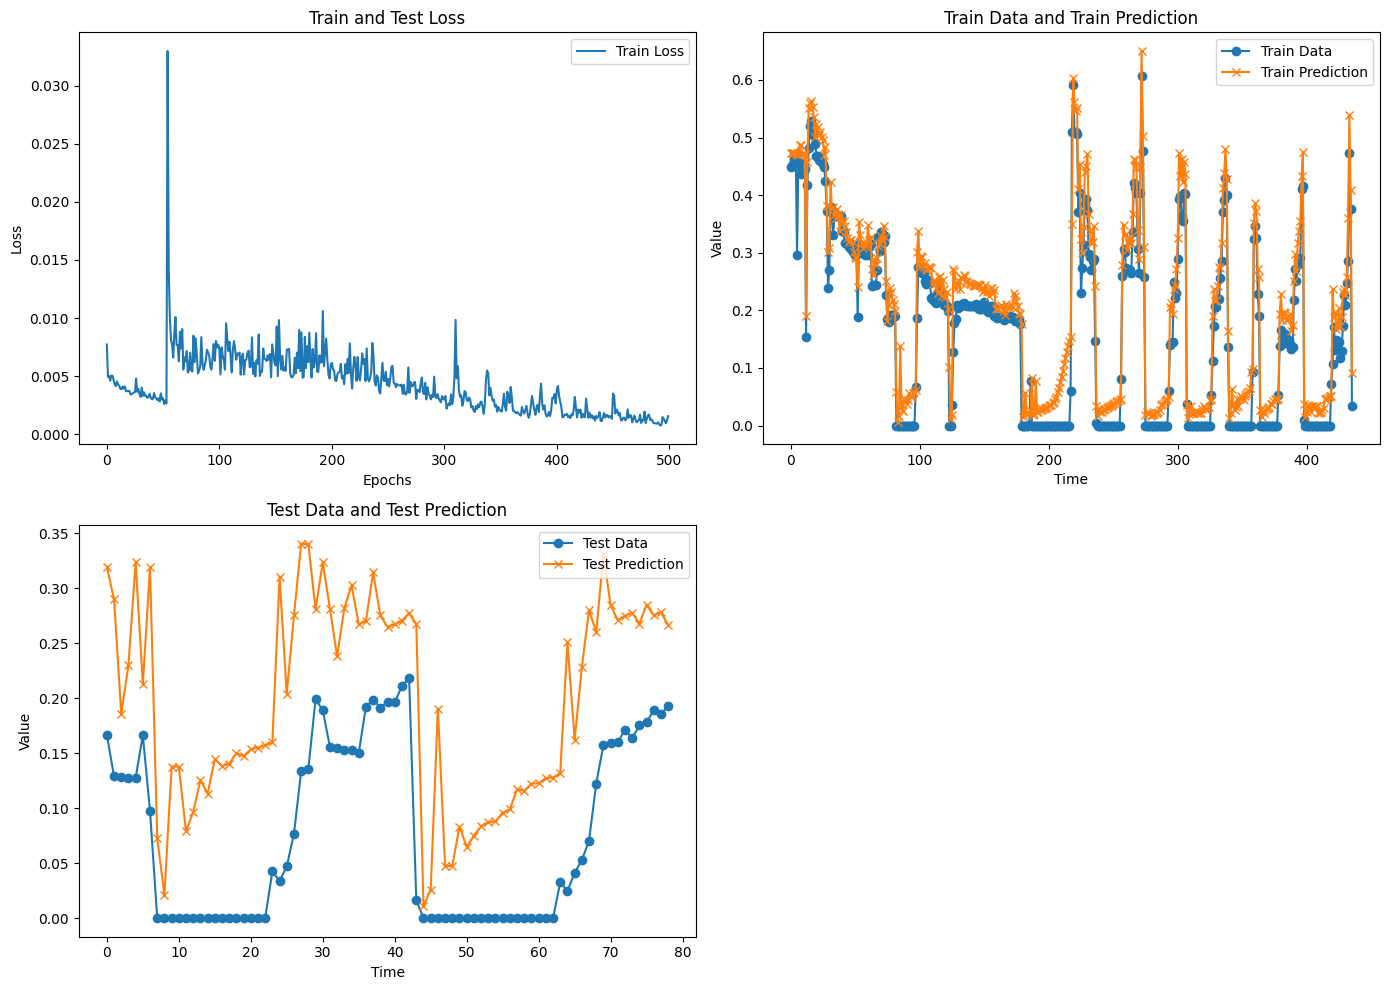

In [33]:
plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

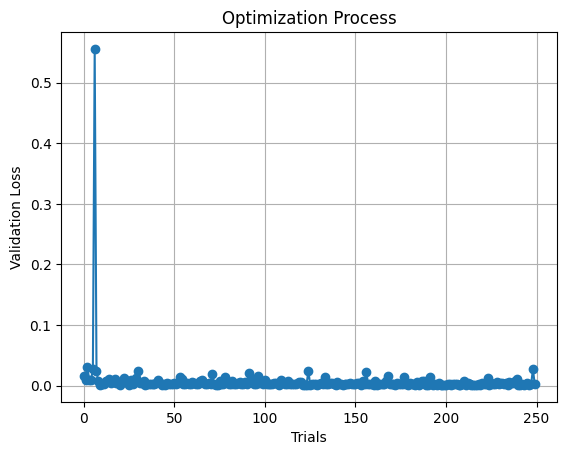

In [34]:
# Extract the validation losses for all trials
val_losses = [trial.value for trial in study.trials]
# Create a plot of validation losses
plt.plot(val_losses, marker='o')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Optimization Process')
plt.grid(True)
plt.show()

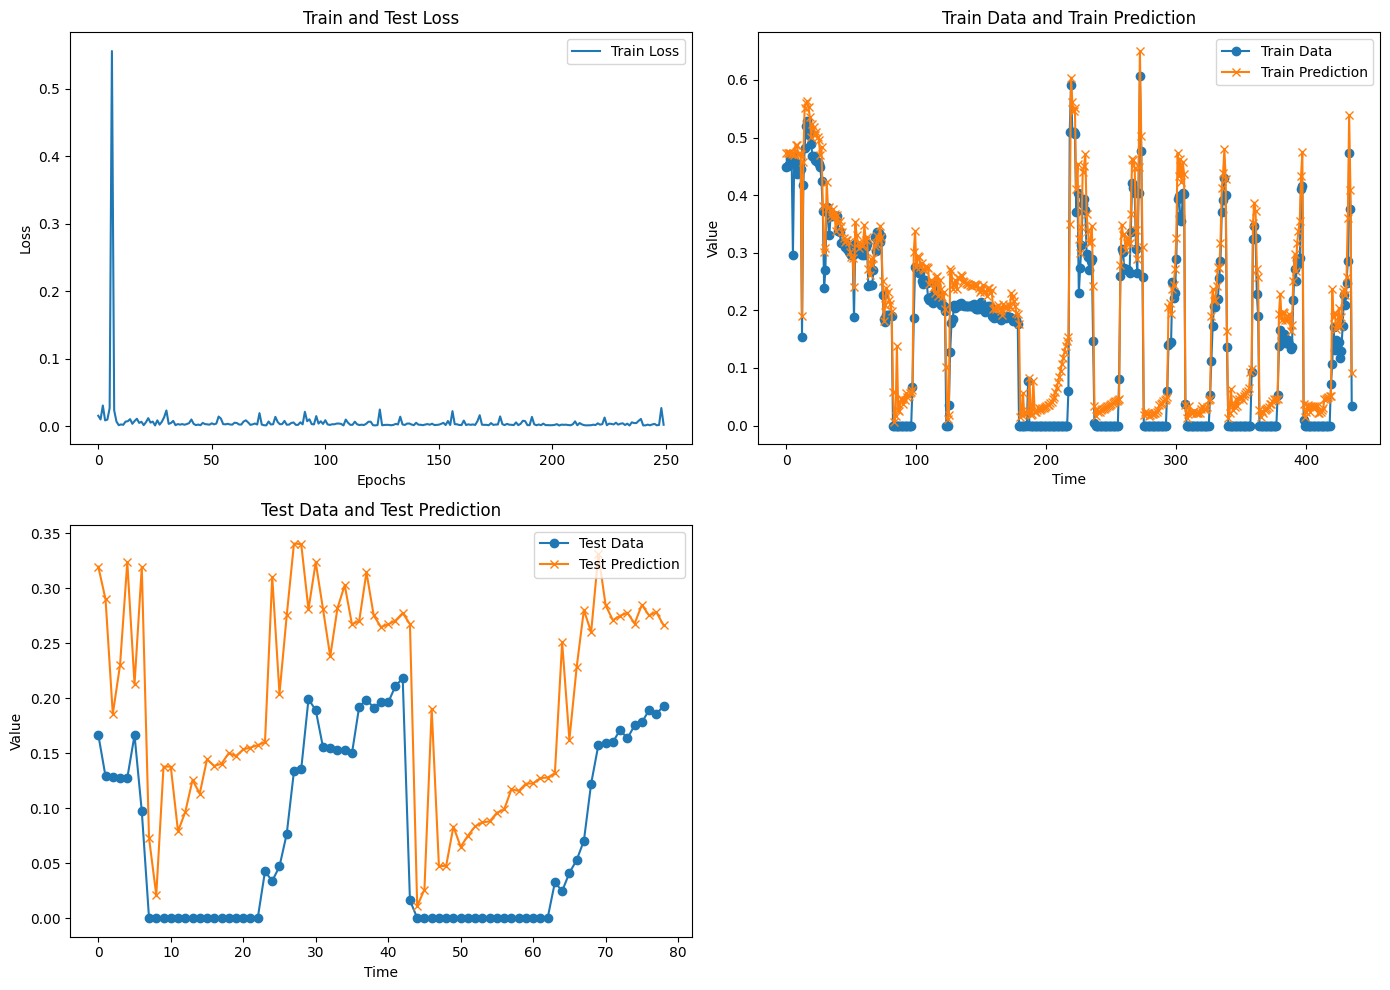

In [35]:
# Plot the graphs
plot_result_graphs(val_losses, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

### Agora vamos criar o modelo com a melhor solução

In [36]:
# model_LSTM = Sequential()
# model_LSTM.reset_states()
# # model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim)))
# model_LSTM.add(LSTM(n_neurons, input_shape=(time_steps, input_dim), return_sequences=True))
# # model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(Dropout(0.2))  # Add dropout with a certain rate (e.g., 20%)
# model_LSTM.add(LSTM(n_neurons, return_sequences=True))
# model_LSTM.add(LSTM(n_neurons, return_sequences=False))
# model_LSTM.add(Dense(output_dim))
# model_LSTM.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [37]:
# # Train the model
# history_LSTM = model_LSTM.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)
# train_loss_history_LSTM = history_LSTM.history['loss']

In [38]:
# # Make predictions using the testing data
# y_train_pred_LSTM = model_LSTM.predict(X_train)
# y_test_pred_LSTM = model_LSTM.predict(X_test)

In [39]:
# # Calculate Mean Squared Error (MSE)
# train_mse_LSTM = mean_squared_error(y_train, y_train_pred_LSTM)
# test_mse_LSTM = mean_squared_error(y_test, y_test_pred_LSTM)
# print("Train MSE:", train_mse_LSTM)
# print("Test MSE:", test_mse_LSTM)

In [40]:
# # Plot the graphs
# plot_result_graphs(train_loss_history_LSTM, y_train, y_train_pred_LSTM, y_test, y_test_pred_LSTM)

## Plot dos modelos

In [41]:
# from keras.utils.vis_utils import plot_model


In [42]:
# plot_model(model_LSTM)

In [43]:
class GroundTruthPreviousValue:
    def generate_data(self, input_data):
        num_samples = len(input_data)
        output_data = np.zeros(num_samples)

        for i in range(1, num_samples):
            output_data[i] = input_data[i - 1]

        return output_data

In [44]:
ground_truth_model_previous_value = GroundTruthPreviousValue()
# Generate the ground truth data using the previous value approach for both training and test datasets
ground_truth_data_train_previous_value = ground_truth_model_previous_value.generate_data(y_train)
ground_truth_data_test_previous_value = ground_truth_model_previous_value.generate_data(y_test)

In [45]:
# Calculate MSE for GroundTruthPreviousValue
mse_train_previous_value = mean_squared_error(ground_truth_data_train_previous_value, y_train)
mse_test_previous_value = mean_squared_error(ground_truth_data_test_previous_value, y_test)

print("Ground Truth Previous Value:")
print(f"Train MSE: {mse_train_previous_value}")
print(f"Test MSE: {mse_test_previous_value}")

Ground Truth Previous Value:
Train MSE: 0.004663358377631685
Test MSE: 0.0013429578358043512


In [46]:
import pandas as pd

def compare_rmse(lstm_train_rmse, lstm_test_rmse, baseline_train_rmse, baseline_test_rmse):
    """
    Compare the MSE of train and test data for different models.

    Parameters:
        rnn_train_rmse (float): MSE of the RNN model on the train data.
        rnn_test_rmse (float): MSE of the RNN model on the test data.
        gru_train_rmse (float): MSE of the GRU model on the train data.
        gru_test_rmse (float): MSE of the GRU model on the test data.
        lstm_train_rmse (float): MSE of the LSTM model on the train data.
        lstm_test_rmse (float): MSE of the LSTM model on the test data.
        baseline_train_rmse (float): MSE of the Baseline model on the train data.
        baseline_test_rmse (float): MSE of the Baseline model on the test data.

    Returns:
        pandas.DataFrame: A table containing the comparison of MSE values for different models.
    """
    model_names = [ 'LSTM', 'Baseline']
    train_mse_values = [lstm_train_rmse, baseline_train_rmse]
    test_mse_values = [ lstm_test_rmse, baseline_test_rmse]

    comparison_df = pd.DataFrame({'Model': model_names,
                                  'Train MSE': train_mse_values,
                                  'Test MSE': test_mse_values})

    return comparison_df

In [47]:
comparison_table = compare_rmse(train_mse_LSTM, test_mse_LSTM, mse_train_previous_value, mse_test_previous_value)
print(comparison_table)

      Model  Train MSE  Test MSE
0      LSTM   0.002033  0.017025
1  Baseline   0.004663  0.001343


In [48]:
# Get the list of suggested hyperparameters for all trials
suggested_hyperparameters = [trial.params for trial in study.trials]

In [49]:
# You can access the suggested hyperparameters for all trials using suggested_hyperparameters
print("Suggested Hyperparameters for All Trials:")
for i, params in enumerate(suggested_hyperparameters):
    print(f"Trial {i + 1}: {params}")

Suggested Hyperparameters for All Trials:
Trial 1: {'window_size': 52, 'batch_size': 7, 'n_lstm_layers': 11, 'lstm_units': 53, 'learning_rate': 0.0046707384277935}
Trial 2: {'window_size': 49, 'batch_size': 5, 'n_lstm_layers': 1, 'lstm_units': 234, 'learning_rate': 0.00877018526722327}
Trial 3: {'window_size': 37, 'batch_size': 4, 'n_lstm_layers': 19, 'lstm_units': 137, 'learning_rate': 0.009164487822926908}
Trial 4: {'window_size': 18, 'batch_size': 5, 'n_lstm_layers': 13, 'lstm_units': 62, 'learning_rate': 0.006244410373110506}
Trial 5: {'window_size': 39, 'batch_size': 8, 'n_lstm_layers': 8, 'lstm_units': 68, 'learning_rate': 0.003745009094202822}
Trial 6: {'window_size': 6, 'batch_size': 20, 'n_lstm_layers': 19, 'lstm_units': 228, 'learning_rate': 0.008952965283197582}
Trial 7: {'window_size': 43, 'batch_size': 1, 'n_lstm_layers': 18, 'lstm_units': 142, 'learning_rate': 0.009092167892241706}
Trial 8: {'window_size': 14, 'batch_size': 5, 'n_lstm_layers': 19, 'lstm_units': 109, 'lear